In [13]:
import matplotlib.pyplot as plt
import numpy as np

# DATOS

In [5]:
from data_ibex35_yahoo import get_data

In [6]:
ibex_data = get_data()

[*********************100%***********************]  34 of 34 completed


3 Failed downloads:
['BKIA.MC', 'REE.MC', 'SGRE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')


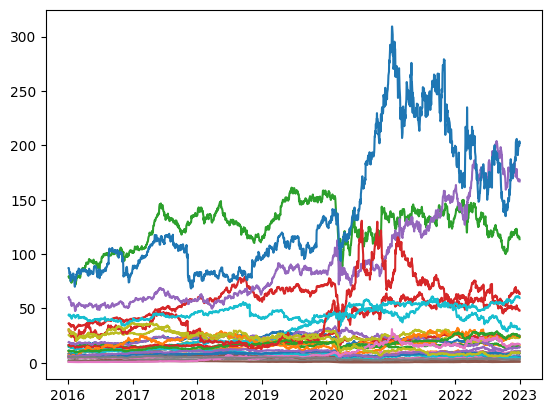

In [9]:
plt.plot(ibex_data);

# X e Y

In [30]:
from market_aux import h_price_to_data

In [31]:
X, Y = h_price_to_data(ibex_data)
X.shape, Y.shape

c:\Users\Julian\Documents\RepositoriosPersonales\GPU_venv\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


((1647, 149, 31), (1647, 31))

## Normalizamos la Y

In [47]:
r_min = np.min(Y, axis=1)[:, np.newaxis]
r_max = np.max(Y, axis=1)[:, np.newaxis]
r_min[-1], r_max[-1]

(array([0], dtype=int64), array([30], dtype=int64))

In [36]:
Y_NORM = 2 * (Y - 0) / (30 - 0) - 1

# 1º Iteracion 
- Comparamos ambas redes con todos los datos
- Comparamos la media del ratio de sharpe calculado con los activos seleccionados en un dato.


# Red neuronal

In [42]:
from my_models import gru_simple_v1_model

In [43]:
RN_model = gru_simple_v1_model(X, Y_NORM)

In [44]:
RN_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 149, 31)]         0         
                                                                 
 gru_3 (GRU)                 (None, 1)                 102       
                                                                 
 dropout_3 (Dropout)         (None, 1)                 0         
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
 flatten_3 (Flatten)         (None, 1)                 0         
                                                                 
 dense_7 (Dense)             (None, 31)                62        
                                                                 
Total params: 166
Trainable params: 166
Non-trainable param

In [45]:
h = RN_model.fit(X[0:800],Y_NORM[0:800],
          epochs=400,
          batch_size=X.shape[0],
          validation_data = (X[800:], Y_NORM[800:])
          )

Epoch 1/400
1/1 [==============================] - 12s 12s/step - loss: 267.1227 - val_loss: 263.9837
Epoch 2/400
1/1 [==============================] - 0s 271ms/step - loss: 265.2256 - val_loss: 264.5137
Epoch 3/400
1/1 [==============================] - 0s 183ms/step - loss: 263.4911 - val_loss: 265.2003
Epoch 4/400
1/1 [==============================] - 0s 153ms/step - loss: 261.9155 - val_loss: 266.0460
Epoch 5/400
1/1 [==============================] - 0s 147ms/step - loss: 260.5005 - val_loss: 267.0411
Epoch 6/400
1/1 [==============================] - 0s 139ms/step - loss: 259.2417 - val_loss: 268.1688
Epoch 7/400
1/1 [==============================] - 0s 140ms/step - loss: 258.1365 - val_loss: 269.4079
Epoch 8/400
1/1 [==============================] - 0s 144ms/step - loss: 257.1817 - val_loss: 270.7251
Epoch 9/400
1/1 [==============================] - 0s 134ms/step - loss: 256.3626 - val_loss: 272.0965
Epoch 10/400
1/1 [==============================] - 0s 142ms/step - loss: 

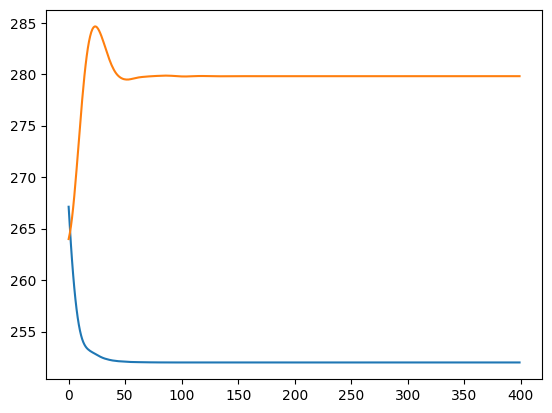

In [46]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])

# Evolutivo

# RN vs EVO